In [120]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
import pydicom
from scipy import stats



import seaborn as sns

##Import any other packages you may need here

In [3]:
os.listdir('/data/')

['FAQ_CHESTXRAY.pdf',
 'ARXIV_V5_CHESTXRAY.pdf',
 'images_009',
 'images_011',
 'images_003',
 'images_004',
 'README_CHESTXRAY.pdf',
 'images_012',
 'images_007',
 'images_005',
 'train_val_list.txt',
 'BBox_List_2017.csv',
 'images_001',
 'images_008',
 'LOG_CHESTXRAY.pdf',
 'images_006',
 'test_list.txt',
 'images_002',
 'images_010',
 'Data_Entry_2017.csv']

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [4]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

Image Index            Finding Labels  Follow-up #  Patient ID  \
4692  00023792_000.png                No Finding            0       23792   
4003  00019765_008.png  Atelectasis|Infiltration            8       19765   
285   00001521_000.png                No Finding            0        1521   

     Patient Age Patient Gender View Position  OriginalImageWidth  \
4692        039Y              M            PA                2048   
4003        072Y              M            PA                2021   
285         056Y              M            AP                2500   

      OriginalImageHeight  OriginalImagePixelSpacing_x  \
4692                 2500                     0.168000   
4003                 2021                     0.194311   
285                  2048                     0.171000   

      OriginalImagePixelSpacing_y  
4692                     0.168000  
4003                     0.194311  
285                      0.171000

In [5]:
sample_df.sample(3)

Image Index Finding Labels  Follow-up #  Patient ID Patient Age  \
3657  00017997_002.png     No Finding            2       17997        039Y   
3629  00017852_013.png     No Finding           13       17852        031Y   
2780  00013917_048.png     No Finding           48       13917        055Y   

     Patient Gender View Position  OriginalImageWidth  OriginalImageHeight  \
3657              M            PA                2021                 2020   
3629              F            PA                2670                 2585   
2780              M            AP                2500                 2048   

      OriginalImagePixelSpacing_x  OriginalImagePixelSpacing_y  
3657                     0.194311                     0.194311  
3629                     0.143000                     0.143000  
2780                     0.168000                     0.168000

In [6]:
## EDA
# Todo 
print(all_xray_df.shape)
all_xray_df.describe()

(112120, 12)


Follow-up #     Patient ID    Patient Age  OriginalImage[Width  \
count  112120.000000  112120.000000  112120.000000        112120.000000   
mean        8.573751   14346.381743      46.901463          2646.078844   
std        15.406320    8403.876972      16.839923           341.246429   
min         0.000000       1.000000       1.000000          1143.000000   
25%         0.000000    7310.750000      35.000000          2500.000000   
50%         3.000000   13993.000000      49.000000          2518.000000   
75%        10.000000   20673.000000      59.000000          2992.000000   
max       183.000000   30805.000000     414.000000          3827.000000   

             Height]  OriginalImagePixelSpacing[x             y]  Unnamed: 11  
count  112120.000000                112120.000000  112120.000000          0.0  
mean     2486.438842                     0.155649       0.155649          NaN  
std       401.268227                     0.016174       0.016174          NaN  
min       966.000000                     0.115000       0.115000          NaN  
25%      2048.000000                     0.143000       0.143000          NaN  
50%      2544.000000                     0.143000       0.143000          NaN  
75%      2991.000000                     0.168000       0.168000          NaN  
max      4715.000000                     0.198800       0.198800          NaN

Max age is 414 which indicates there could be some errors in the data

In [7]:
print('{} Age entries >110'.format(len(all_xray_df[all_xray_df['Patient Age']>110])))
all_xray_df[all_xray_df['Patient Age']>110]

16 Age entries >110


Image Index           Finding Labels  Follow-up #  Patient ID  \
20852   00005567_000.png       Effusion|Pneumonia            0        5567   
46965   00011973_002.png                    Edema            2       11973   
48284   00012238_010.png               No Finding           10       12238   
55742   00013950_000.png               No Finding            0       13950   
58650   00014520_026.png        Infiltration|Mass           26       14520   
62929   00015558_000.png               No Finding            0       15558   
74884   00018366_044.png             Pneumothorax           44       18366   
78795   00019346_000.png             Infiltration            0       19346   
84810   00020900_002.png               No Finding            2       20900   
85404   00021047_002.png  Mass|Pleural_Thickening            2       21047   
86264   00021275_003.png               No Finding            3       21275   
91369   00022811_000.png               No Finding            0       22811   
95794   00025206_000.png        Infiltration|Mass            0       25206   
98495   00026028_001.png              Atelectasis            1       26028   
101194  00026871_000.png               No Finding            0       26871   
104590  00027989_000.png               No Finding            0       27989   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
20852           412              M            AP                 3056   
46965           414              M            AP                 3056   
48284           148              M            PA                 2992   
55742           148              M            PA                 2964   
58650           150              M            PA                 2992   
62929           149              M            PA                 2992   
74884           152              F            PA                 2302   
78795           151              F            PA                 2678   
84810           411              M            AP                 3056   
85404           412              M            AP                 3056   
86264           413              F            AP                 3056   
91369           412              M            PA                 3056   
95794           153              M            PA                 2992   
98495           154              M            PA                 2992   
101194          155              F            PA                 2992   
104590          155              M            PA                 2992   

        Height]  OriginalImagePixelSpacing[x     y]  Unnamed: 11  
20852      2544                        0.139  0.139          NaN  
46965      2544                        0.139  0.139          NaN  
48284      2991                        0.143  0.143          NaN  
55742      2939                        0.143  0.143          NaN  
58650      2991                        0.143  0.143          NaN  
62929      2991                        0.143  0.143          NaN  
74884      2991                        0.143  0.143          NaN  
78795      2774                        0.143  0.143          NaN  
84810      2544                        0.139  0.139          NaN  
85404      2544                        0.139  0.139          NaN  
86264      2544                        0.139  0.139          NaN  
91369      2544                        0.139  0.139          NaN  
95794      2991                        0.143  0.143          NaN  
98495      2991                        0.143  0.143          NaN  
101194     2991                        0.143  0.143          NaN  
104590     2991                        0.143  0.143          NaN

Going to drop these entries as I don't have confidence that these have been entered correctly. Also dropping the Unnamed column as this just contains NaNs

In [8]:
subset_xray_df = all_xray_df[all_xray_df['Patient Age']<110]
subset_xray_df = subset_xray_df.drop(columns='Unnamed: 11')
print(subset_xray_df.shape)
subset_xray_df.describe()

(112104, 11)


Follow-up #     Patient ID    Patient Age  OriginalImage[Width  \
count  112104.000000  112104.000000  112104.000000        112104.000000   
mean        8.574172   14345.720724      46.872574          2646.035253   
std        15.406734    8403.980520      16.598152           341.243771   
min         0.000000       1.000000       1.000000          1143.000000   
25%         0.000000    7308.000000      35.000000          2500.000000   
50%         3.000000   13993.000000      49.000000          2518.000000   
75%        10.000000   20673.000000      59.000000          2992.000000   
max       183.000000   30805.000000      95.000000          3827.000000   

             Height]  OriginalImagePixelSpacing[x             y]  
count  112104.000000                112104.000000  112104.000000  
mean     2486.393153                     0.155651       0.155651  
std       401.270806                     0.016174       0.016174  
min       966.000000                     0.115000       0.115000  
25%      2048.000000                     0.143000       0.143000  
50%      2544.000000                     0.143000       0.143000  
75%      2991.000000                     0.168000       0.168000  
max      4715.000000                     0.198800       0.198800

# 1) Population Demographics

## Patient Gender

Trained on both male and female patients. Relatively balanced between two genders.

M    63328
F    48776
Name: Patient Gender, dtype: int64


Text(0.5, 1.0, 'Distribution of gender')

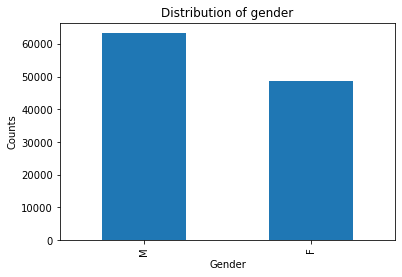

In [9]:
print(subset_xray_df['Patient Gender'].value_counts())
subset_xray_df['Patient Gender'].value_counts().plot(kind='bar')
plt.ylabel('Counts')
plt.xlabel('Gender')
plt.title('Distribution of gender')

## Patient Age

Patient age ranges from a min of 1 to a max of 95. The mean age is 47.

Text(0.5, 1.0, 'Distribution of ages')

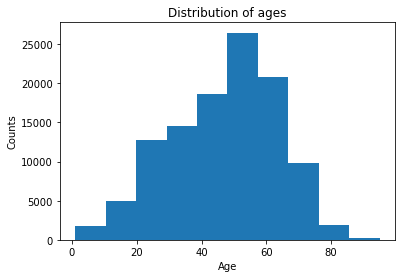

In [10]:
plt.hist(subset_xray_df['Patient Age'])
plt.ylabel('Counts')
plt.xlabel('Age')
plt.title('Distribution of ages')

## View Position

Xrays were taken in two view positions

Text(0.5, 0, 'View Position')

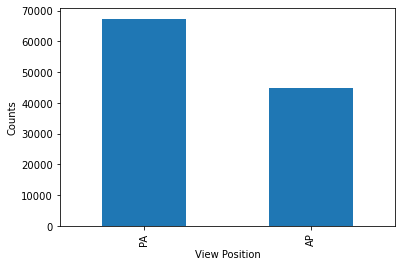

In [11]:
subset_xray_df['View Position'].value_counts().plot(kind='bar')
plt.ylabel('Counts')
plt.xlabel('View Position')


# 2) Number of Cases

* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
    

In [12]:
subset_xray_df['Finding Labels'].value_counts()[0:20]

No Finding                           60353
Infiltration                          9546
Atelectasis                           4214
Effusion                              3955
Nodule                                2705
Pneumothorax                          2193
Mass                                  2139
Effusion|Infiltration                 1603
Atelectasis|Infiltration              1350
Consolidation                         1310
Atelectasis|Effusion                  1165
Pleural_Thickening                    1126
Cardiomegaly                          1093
Emphysema                              892
Infiltration|Nodule                    829
Atelectasis|Effusion|Infiltration      737
Fibrosis                               727
Edema                                  627
Cardiomegaly|Effusion                  484
Consolidation|Infiltration             441
Name: Finding Labels, dtype: int64

In [13]:
## split up "Finding Labels" column so that I have one column in my dataframe
# per disease, with a binary flag

all_labels = np.unique(list(chain(*subset_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
# how many labels|

print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        subset_xray_df[c_label] = subset_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
subset_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


Image Index                                 Finding Labels  \
3483   00000938_003.png            Consolidation|Effusion|Infiltration   
8972   00002356_010.png                                     No Finding   
65211  00016094_028.png  Consolidation|Infiltration|Pleural_Thickening   

       Follow-up #  Patient ID  Patient Age Patient Gender View Position  \
3483             3         938           58              F            AP   
8972            10        2356           68              F            PA   
65211           28       16094           26              M            PA   

       OriginalImage[Width  Height]  OriginalImagePixelSpacing[x  ...  \
3483                  3056     2544                        0.139  ...   
8972                  2544     3056                        0.139  ...   
65211                 2992     2991                        0.143  ...   

       Emphysema  Fibrosis  Hernia  Infiltration  Mass  No Finding  Nodule  \
3483         0.0       0.0     0.0           1.0   0.0         0.0     0.0   
8972         0.0       0.0     0.0           0.0   0.0         1.0     0.0   
65211        0.0       0.0     0.0           1.0   0.0         0.0     0.0   

       Pleural_Thickening  Pneumonia  Pneumothorax  
3483                  0.0        0.0           0.0  
8972                  0.0        0.0           0.0  
65211                 1.0        0.0           0.0  

[3 rows x 26 columns]

[Text(0, 0.5, 'Number of Images with Label')]

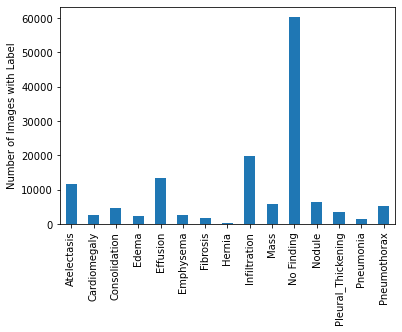

In [14]:
ax = subset_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

There are 15 unique types of labels in the dataset. The most common label is No Finding. Followed by Infiltration and Effusion

In [15]:
print('Number of cases: {}'.format(len(subset_xray_df)))
print('Number of pneumonia cases: {}'.format(subset_xray_df.Pneumonia.value_counts()[1]))
print('Number of pneumonia cases: {}'.format(subset_xray_df.Pneumonia.value_counts()[0]))



Number of cases: 112104
Number of pneumonia cases: 1430
Number of pneumonia cases: 110674


Positive and negative classes are imbalanced so we will need to take this into account when creating our test/train sets. In the train set classes should be balanced so we will need to discard some of the negative records.

# 3) Disease Distribution

* The distribution of other diseases that are comorbid with pneumonia


In [16]:
# Pnemonia cases
print('Number of different disease combinations')
print(len(subset_xray_df[subset_xray_df.Pneumonia==1.0]['Finding Labels'].value_counts()))  
subset_xray_df[subset_xray_df.Pneumonia==1.0]['Finding Labels'].value_counts()[0:30]

Number of different disease combinations
142


Pneumonia                                          322
Infiltration|Pneumonia                             199
Edema|Infiltration|Pneumonia                       137
Atelectasis|Pneumonia                              108
Edema|Pneumonia                                     83
Effusion|Pneumonia                                  53
Effusion|Infiltration|Pneumonia                     42
Consolidation|Pneumonia                             36
Atelectasis|Infiltration|Pneumonia                  34
Atelectasis|Effusion|Pneumonia                      23
Edema|Effusion|Infiltration|Pneumonia               21
Edema|Effusion|Pneumonia                            19
Nodule|Pneumonia                                    19
Atelectasis|Effusion|Infiltration|Pneumonia         18
Atelectasis|Consolidation|Pneumonia                 15
Consolidation|Infiltration|Pneumonia                13
Pleural_Thickening|Pneumonia                        11
Mass|Pneumonia                                      11
Infiltrati

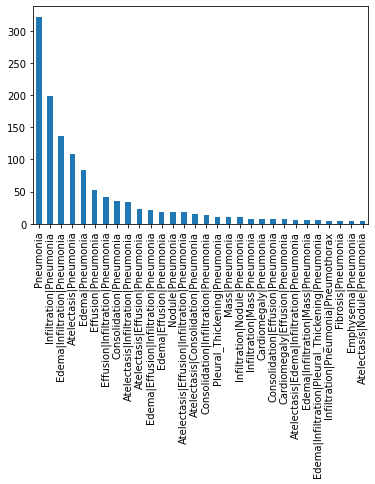

In [17]:
subset_xray_df[subset_xray_df.Pneumonia==1.0]['Finding Labels'].value_counts()[0:30].plot(kind = 'bar')

Pneumonia occurs most frequently alone. The most frequent comorbidities for Pneumonia are Infiltration, Edema and Atelectasis

# 5) Number of diseases per patient

In [18]:
# add a new column with the number of diseases per patient
# ignore no finding because that doesn't indicate a disease
subset_xray_df['n_diseases'] = subset_xray_df[
    'Finding Labels'].apply(lambda x: len(x.split('|') ) if 'No Find' not in x else 0 )  

In [19]:
# inspect the results
subset_xray_df[['Finding Labels','n_diseases']]

Finding Labels  n_diseases
0                 Cardiomegaly           1
1       Cardiomegaly|Emphysema           2
2        Cardiomegaly|Effusion           2
3                   No Finding           0
4                       Hernia           1
...                        ...         ...
112115          Mass|Pneumonia           2
112116              No Finding           0
112117              No Finding           0
112118              No Finding           0
112119              No Finding           0

[112104 rows x 2 columns]

Text(0.5, 1.0, 'Num diseases per patient distribution')

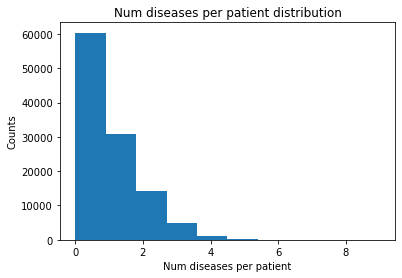

In [20]:
plt.hist(subset_xray_df.n_diseases)
plt.ylabel('Counts')
plt.xlabel('Num diseases per patient')
plt.title('Num diseases per patient distribution')

Patients most frequently have 1 disease. 

# 6) Pixel Level Analysis

* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

In [21]:
#  Read all image paths into a dict
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}

In [22]:
all_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
# how many labels

print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
sample_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


Image Index       Finding Labels  Follow-up #  Patient ID  \
4108  00020228_000.png           No Finding            0       20228   
4122  00020298_000.png  Infiltration|Nodule            0       20298   
2796  00013979_000.png           No Finding            0       13979   

     Patient Age Patient Gender View Position  OriginalImageWidth  \
4108        026Y              M            PA                2458   
4122        026Y              M            PA                3056   
2796        071Y              F            AP                2500   

      OriginalImageHeight  OriginalImagePixelSpacing_x  ...  Emphysema  \
4108                 2745                        0.143  ...        0.0   
4122                 2488                        0.139  ...        0.0   
2796                 2048                        0.168  ...        0.0   

      Fibrosis  Hernia  Infiltration  Mass  No Finding  Nodule  \
4108       0.0     0.0           0.0   0.0         1.0     0.0   
4122       0.0     0.0           1.0   0.0         0.0     1.0   
2796       0.0     0.0           0.0   0.0         1.0     0.0   

      Pleural_Thickening  Pneumonia  Pneumothorax  
4108                 0.0        0.0           0.0  
4122                 0.0        0.0           0.0  
2796                 0.0        0.0           0.0  

[3 rows x 26 columns]

In [127]:
def plot_image_distributions(image_list, disease):
    for counter, image in enumerate(image_list):
        img = plt.imread(all_image_paths[image])
        fig, ax = plt.subplots(1,2, figsize=(15,5))
        ax[0].imshow(img, cmap='gray')

#       normalise
        mean_intensity = np.mean(img)
        std_intensity = np.std(img)

        norm_img = (img - mean_intensity)/std_intensity
        ax[1].hist(img.ravel(), bins = 256)
        ax[0].set_title(disease + ' image ' + str(counter +1))
        ax[1].set_title('pixel intensity distribution')
        ax[1].set_ylim(0, 40000)  # plotting all on same y axes so for ease of comparison


In [67]:
pneumonia_img = sample_df[sample_df['Finding Labels']=='Pneumonia']['Image Index'].iloc[2:5].values
no_finding_img = sample_df[sample_df['No Finding']==1]['Image Index'].iloc[0:3].values


In [118]:
# isolate three images for each disease
img_index = pd.DataFrame(columns = all_labels)
for label, content in img_index.items():
    img_index[label] = sample_df[sample_df['Finding Labels']==label]['Image Index'].iloc[2:5].values
img_index.head()


Atelectasis      Cardiomegaly     Consolidation             Edema  \
0  00000175_002.png  00001373_021.png  00001255_033.png  00001504_009.png   
1  00000642_000.png  00001373_026.png  00002048_013.png  00002412_000.png   
2  00000816_000.png  00001385_004.png  00002425_000.png  00002533_003.png   

           Effusion         Emphysema          Fibrosis            Hernia  \
0  00000096_006.png  00000682_001.png  00000545_004.png  00008015_000.png   
1  00000099_003.png  00001047_002.png  00000733_003.png  00008694_002.png   
2  00000127_007.png  00001833_005.png  00001409_002.png  00012833_000.png   

       Infiltration              Mass        No Finding            Nodule  \
0  00000246_011.png  00000627_036.png  00000057_001.png  00000954_005.png   
1  00000250_005.png  00001075_004.png  00000061_019.png  00001248_005.png   
2  00000268_001.png  00001187_002.png  00000080_005.png  00001836_100.png   

  Pleural_Thickening         Pneumonia      Pneumothorax  
0   00000981_002.png  00012158_025.png  00000467_013.png  
1   00001990_002.png  00012667_000.png  00000832_005.png  
2   00002003_005.png  00012733_000.png  00001968_000.png

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


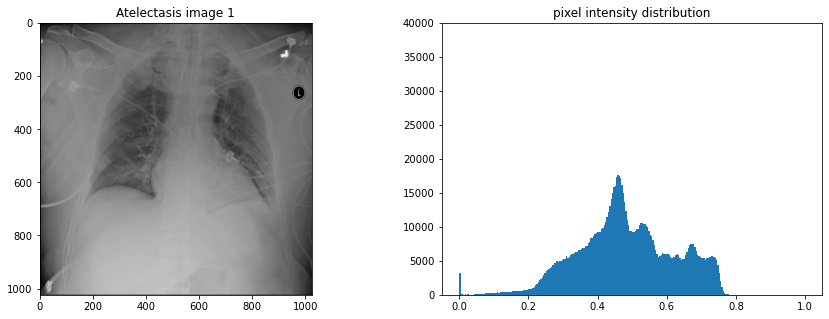

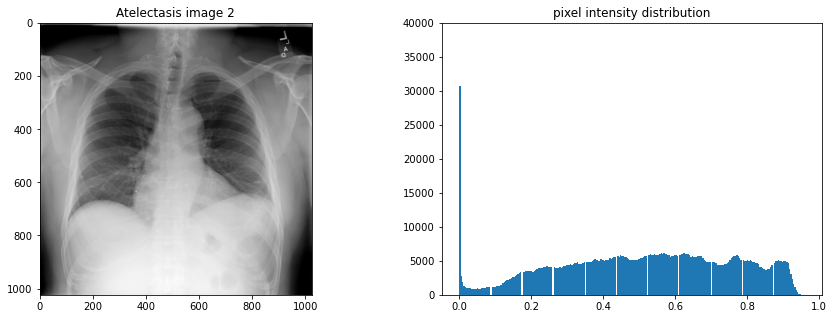

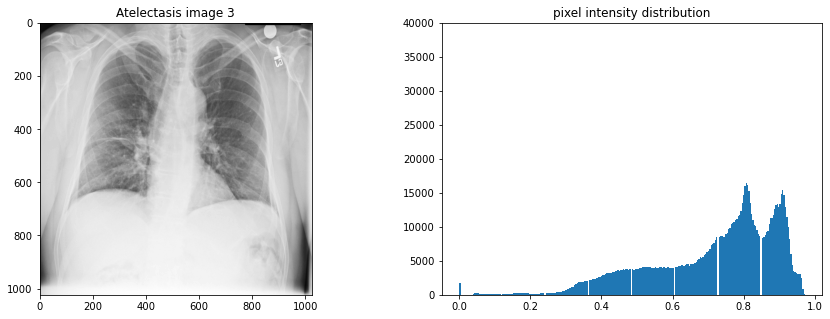

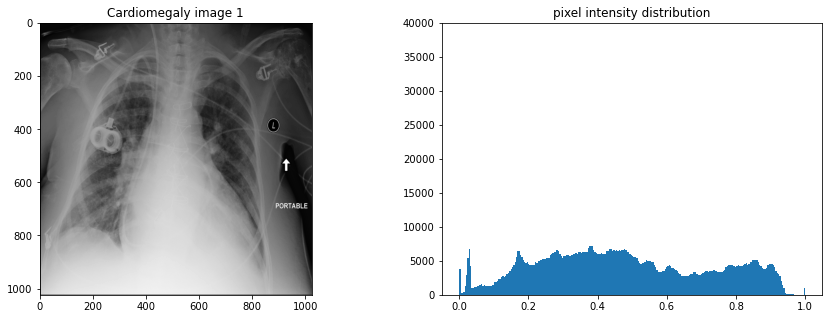

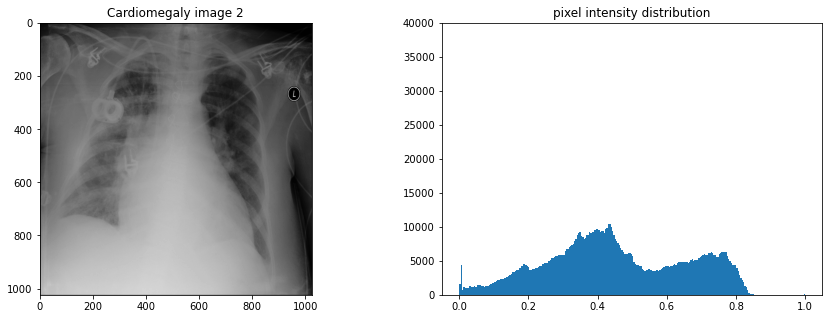

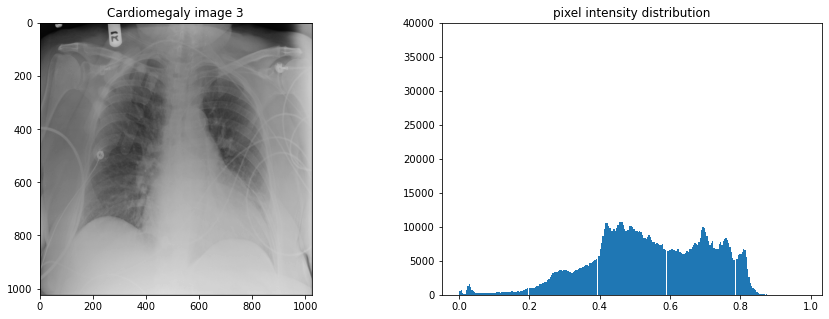

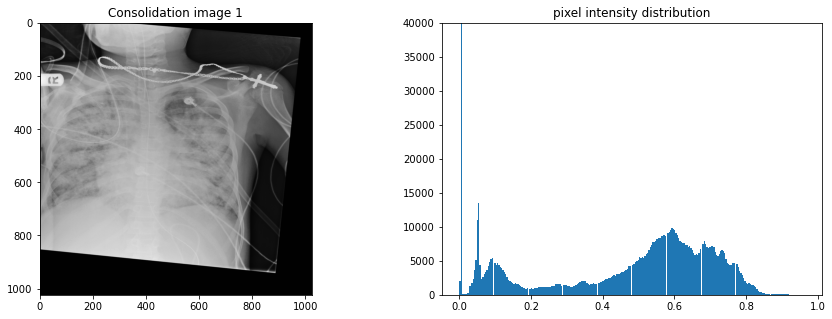

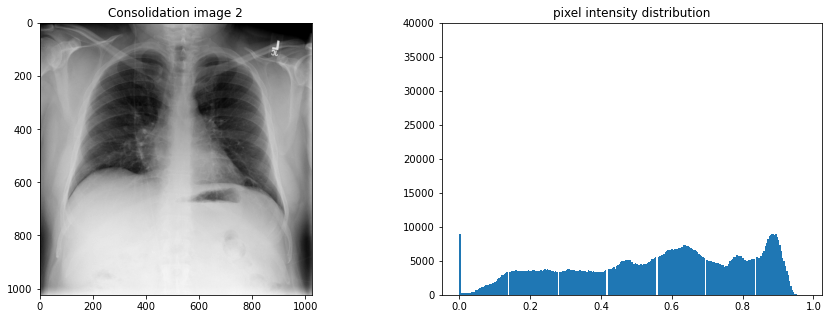

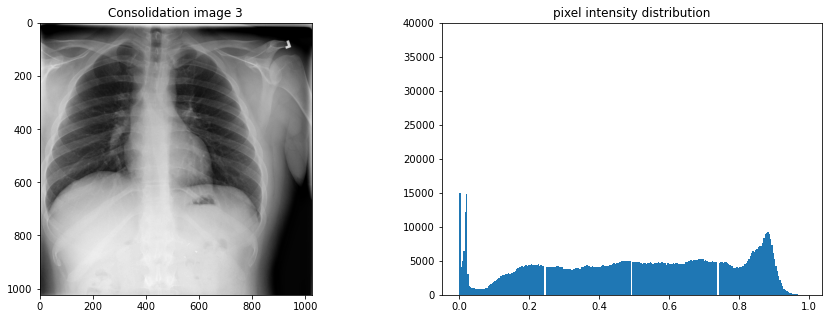

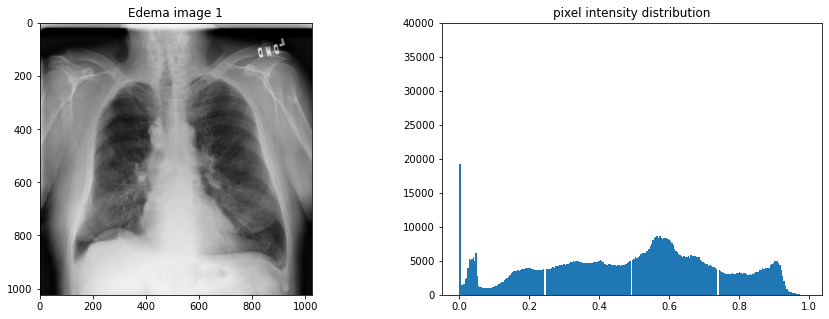

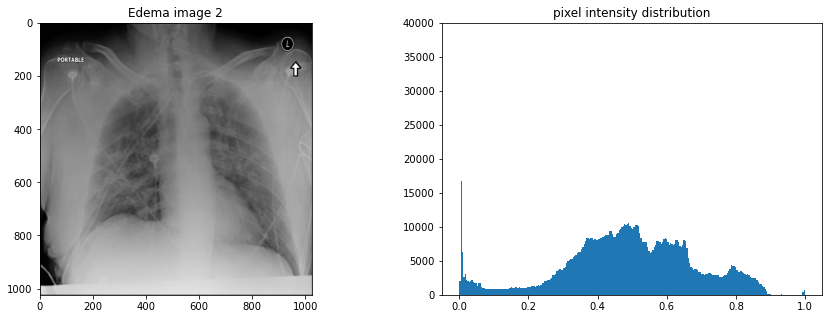

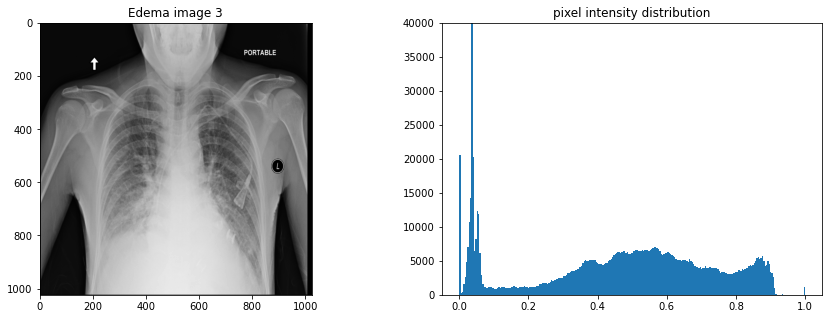

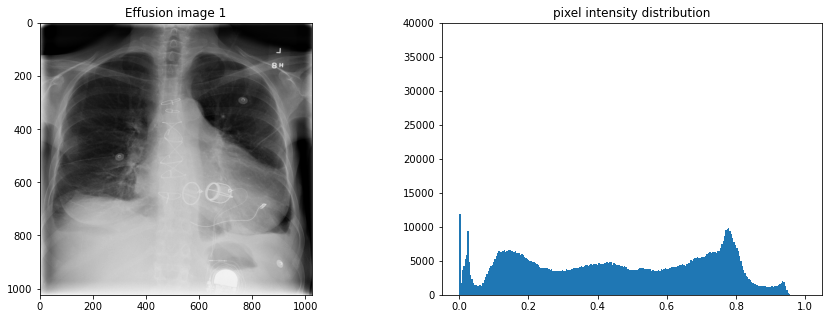

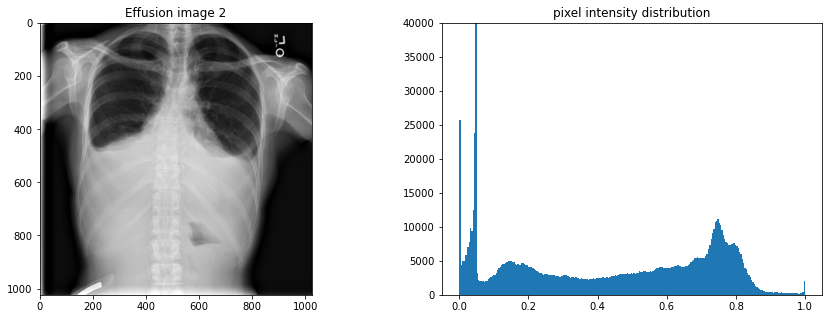

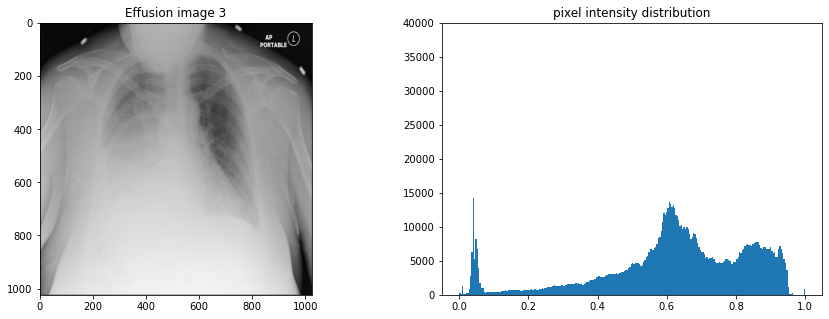

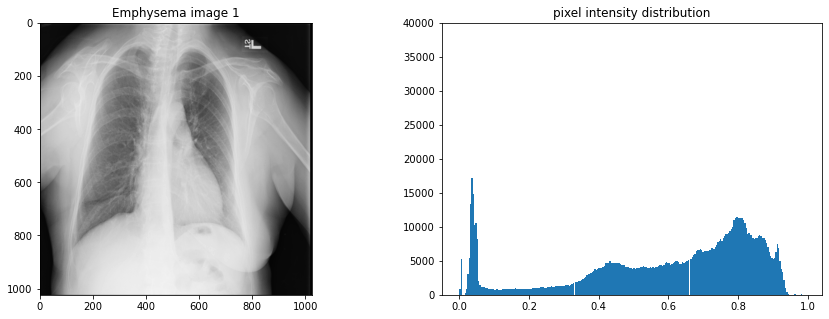

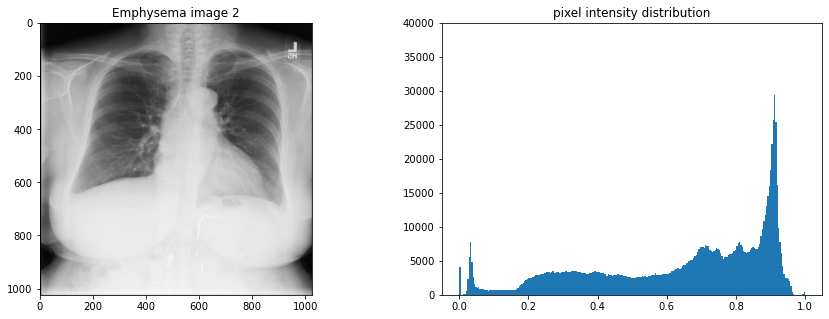

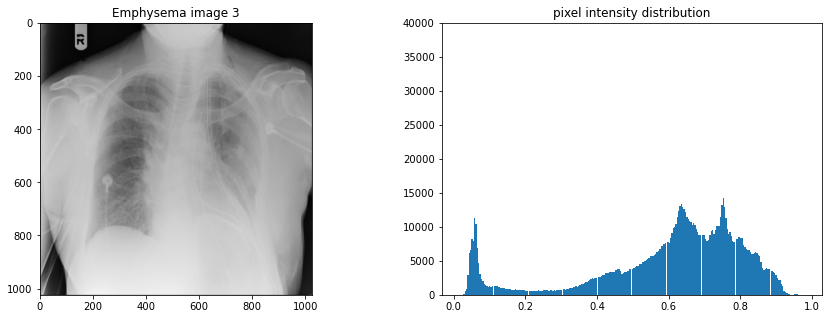

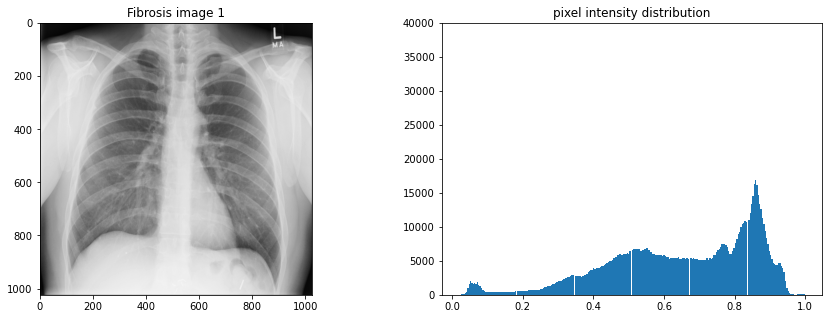

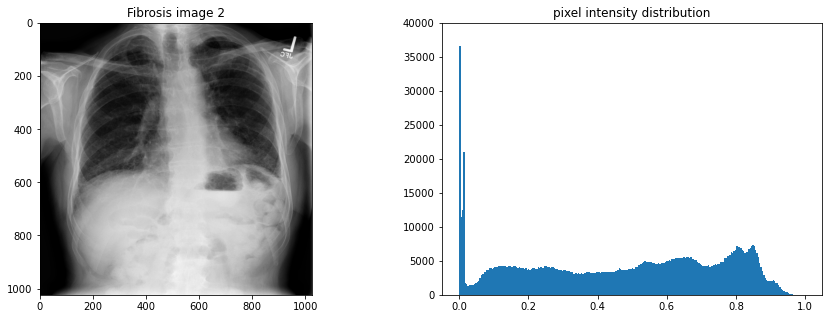

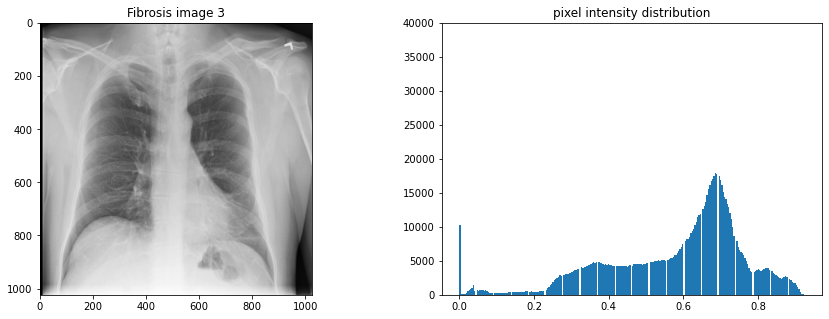

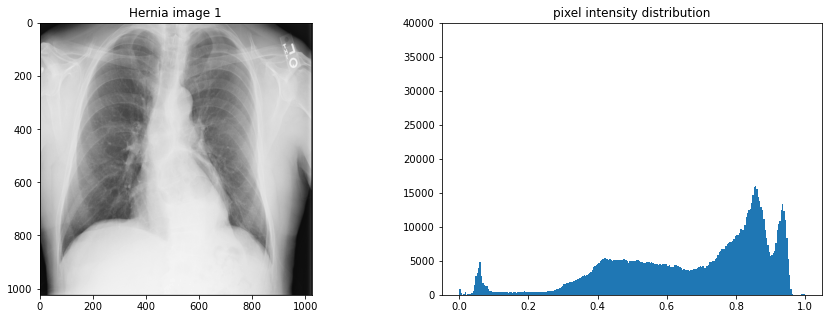

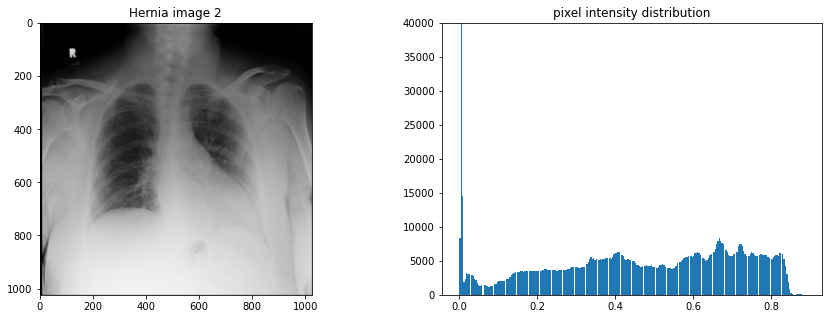

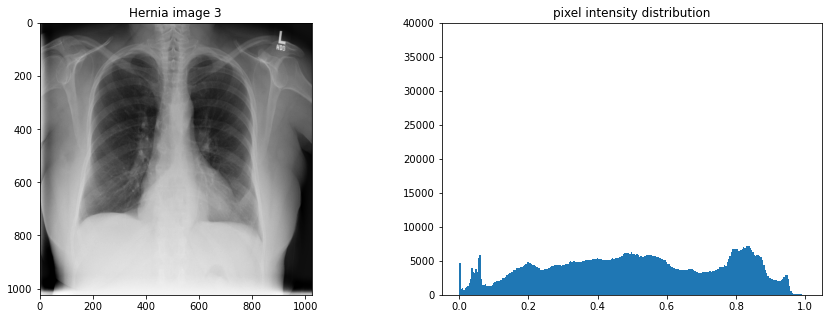

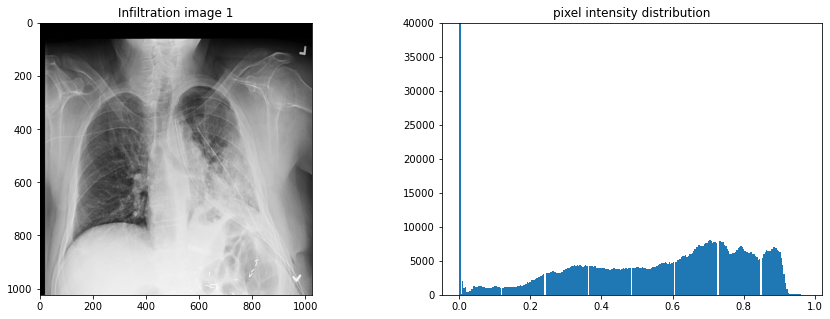

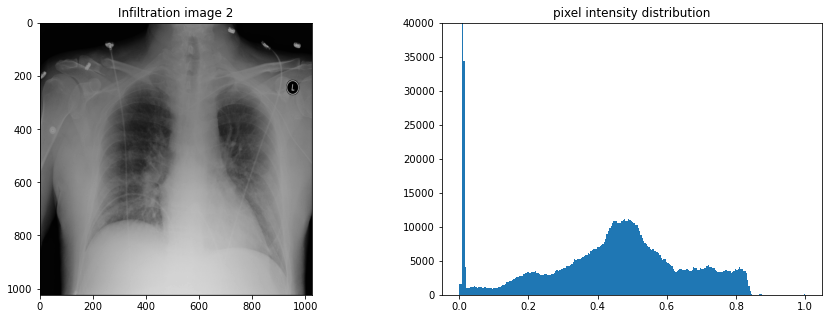

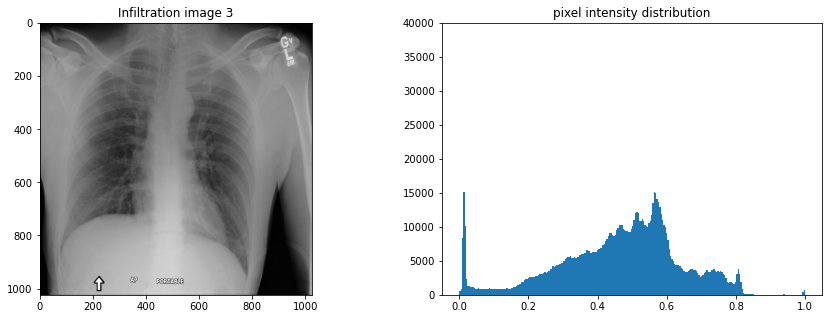

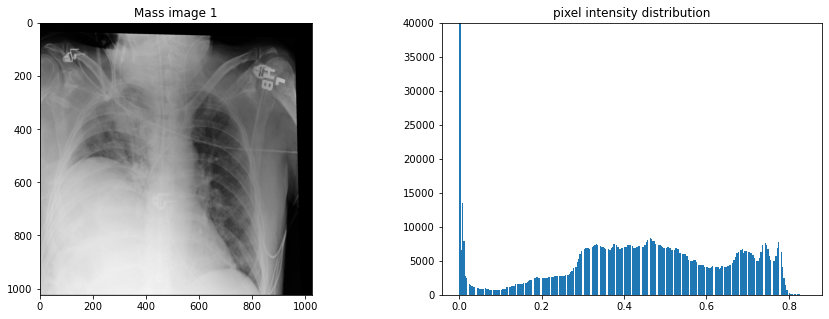

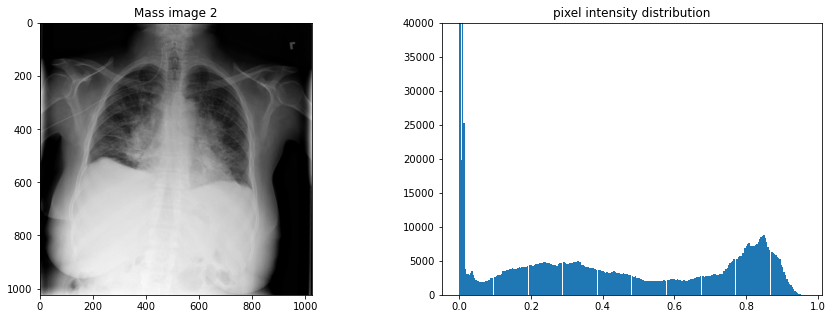

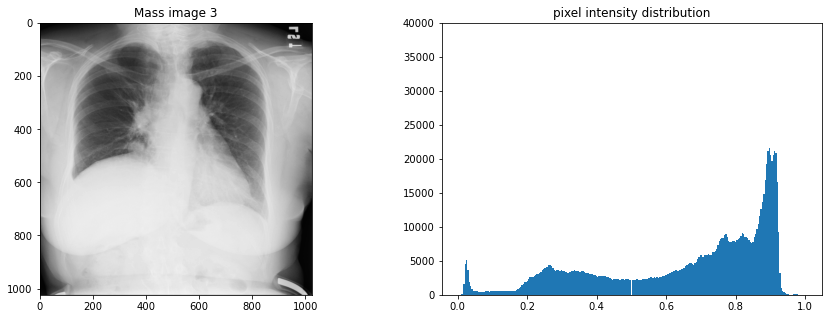

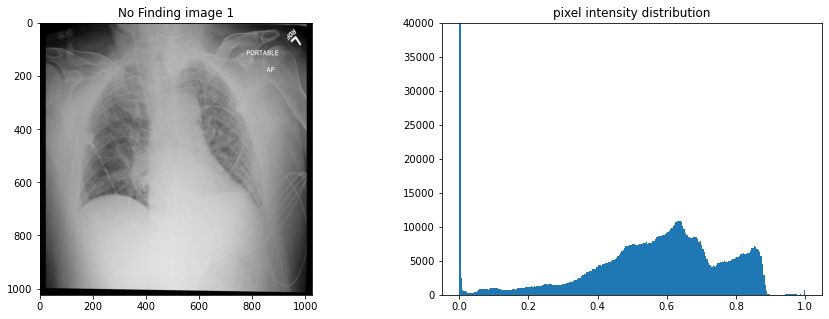

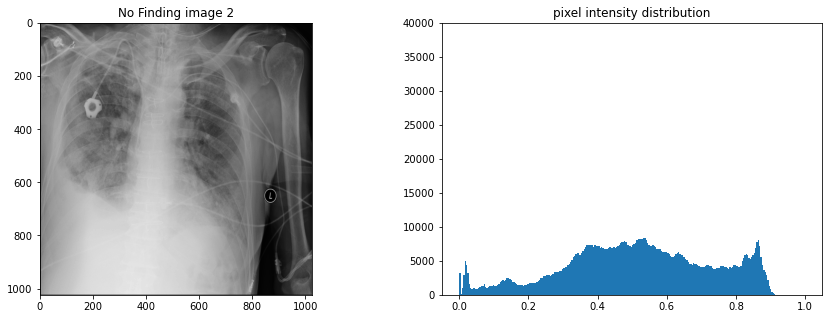

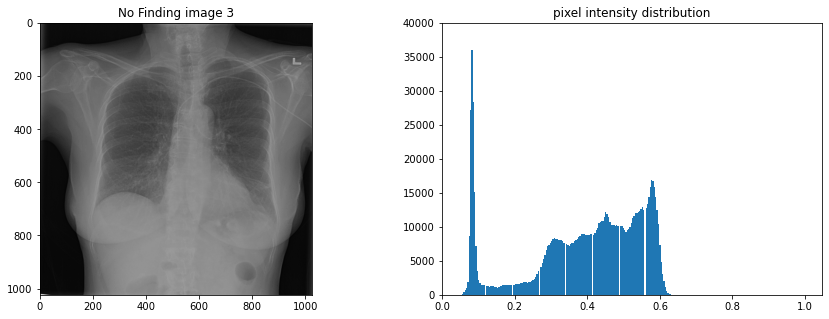

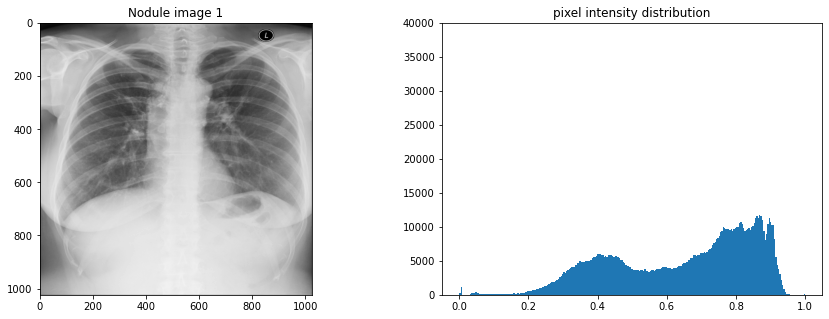

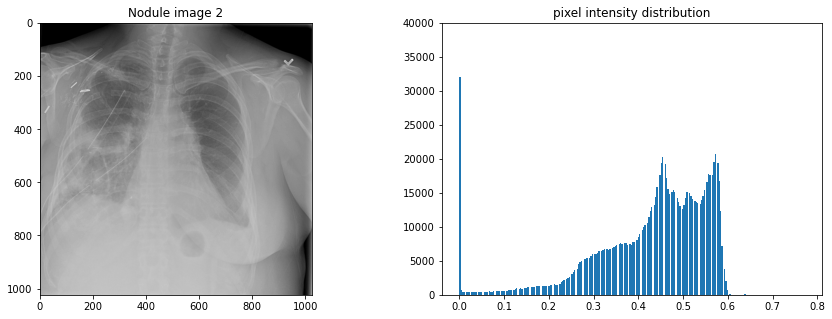

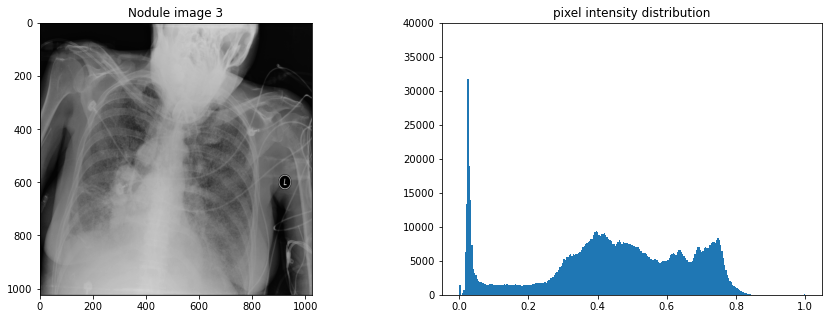

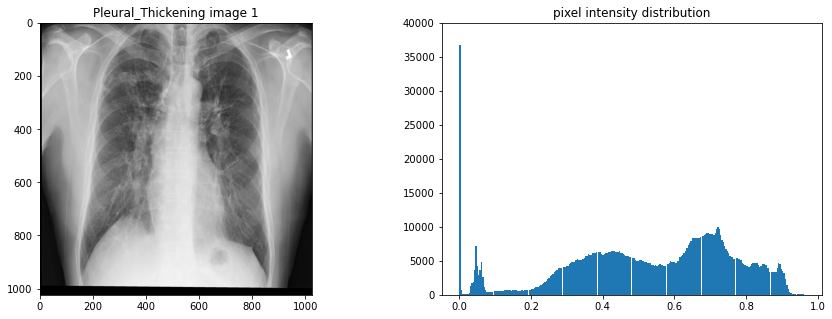

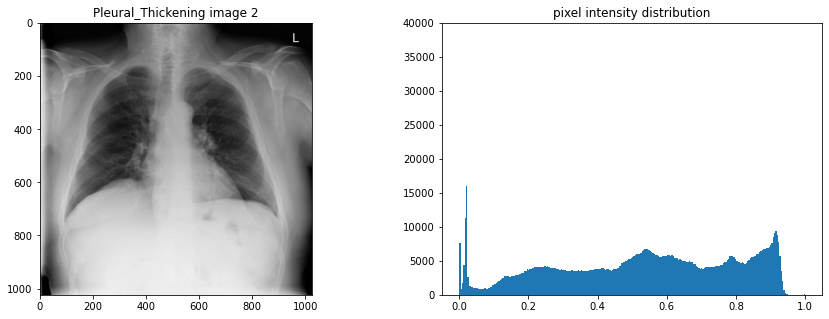

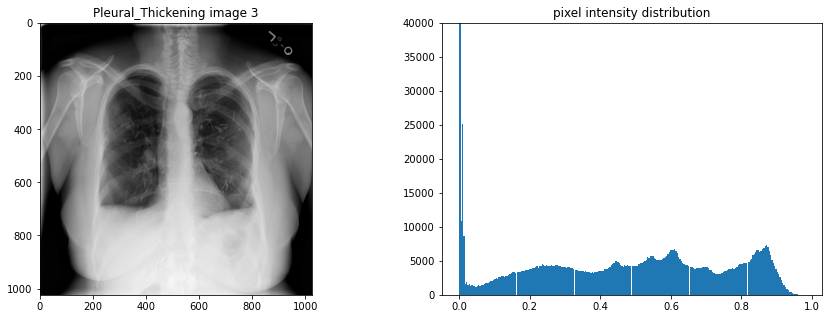

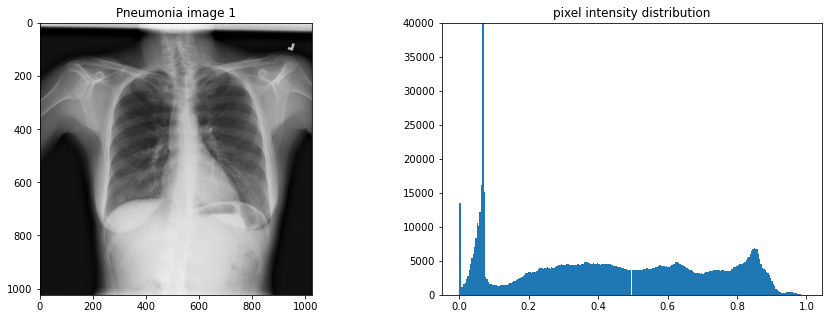

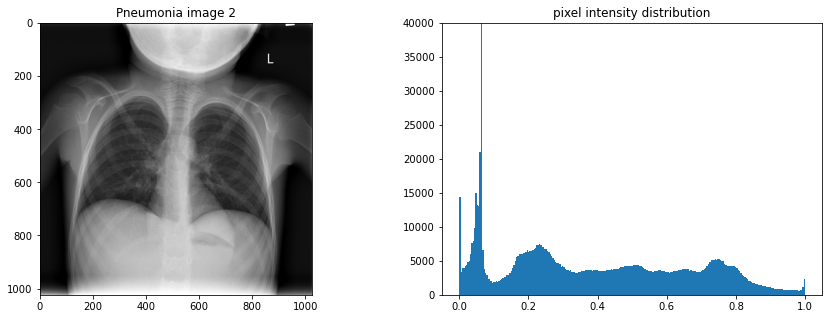

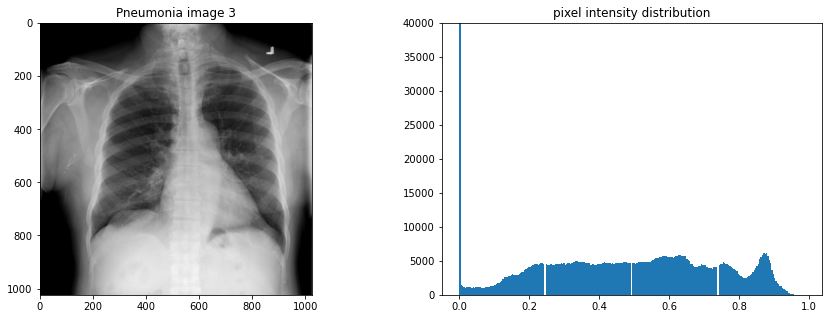

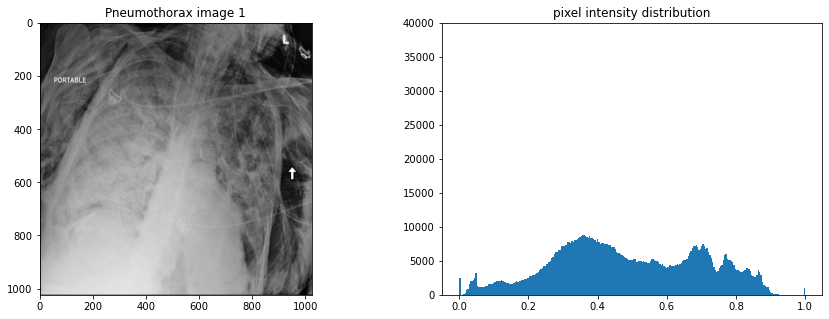

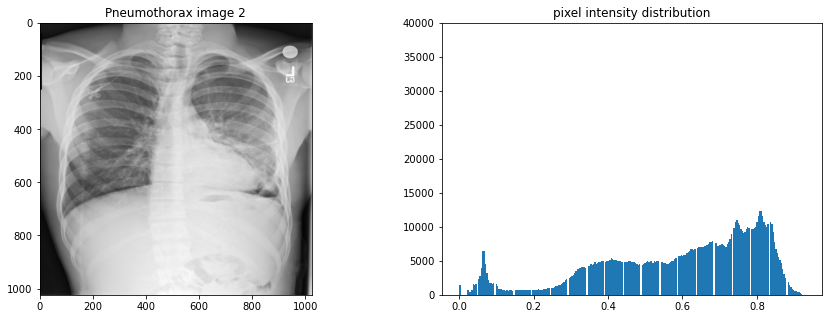

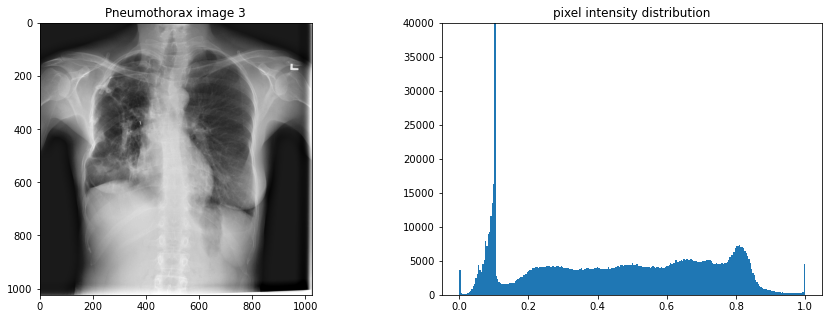

In [128]:
for label, series in img_index.items():
    plot_image_distributions(series, label)

### No Finding

0.61305344
ModeResult(mode=array([[0.43529412, 0.7607843 , 0.04705882, ..., 0.04705882, 0.04705882,
        0.03137255]], dtype=float32), count=array([[134, 100,  97, ...,  91,  80, 102]]))
0.49448156
ModeResult(mode=array([[0.        , 0.02745098, 0.08627451, ..., 0.07058824, 0.07058824,
        0.07058824]], dtype=float32), count=array([[1024,  240,  113, ...,   82,   73,   94]]))
0.55088806
ModeResult(mode=array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32), count=array([[1024, 1024, 1024, ..., 1024, 1024, 1024]]))


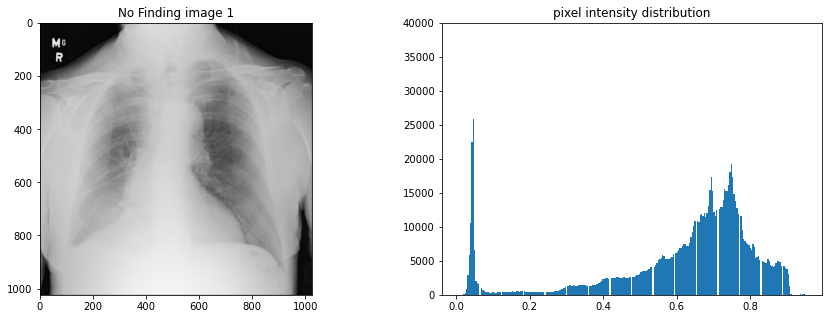

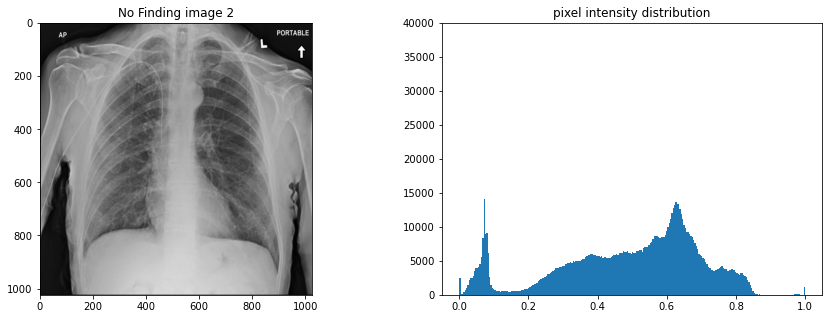

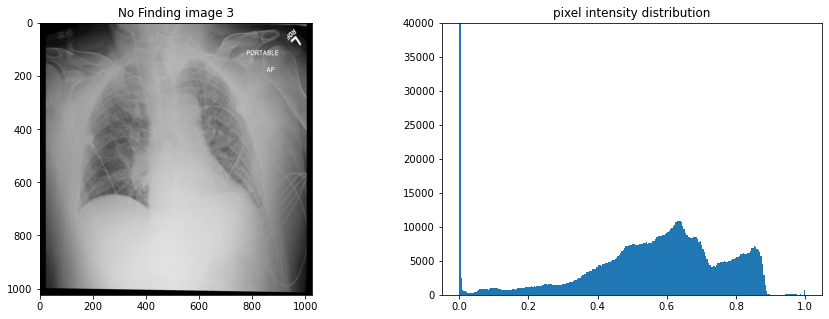

In [123]:
plot_image_distributions(no_finding_img, 'No Finding')

### Pneumonia

0.4200332
ModeResult(mode=array([[0.06666667, 0.06666667, 0.06666667, ..., 0.06666667, 0.05098039,
        0.        ]], dtype=float32), count=array([[559, 556, 556, ..., 544, 544, 699]]))
0.38777718
ModeResult(mode=array([[0.0627451 , 0.0627451 , 0.0627451 , ..., 0.07450981, 0.07843138,
        0.08627451]], dtype=float32), count=array([[420, 414, 415, ..., 227, 202, 200]]))
0.44965848
ModeResult(mode=array([[0.        , 0.        , 0.        , ..., 0.04313726, 0.11372549,
        0.64705884]], dtype=float32), count=array([[491, 499, 505, ...,  42,  40,  51]]))


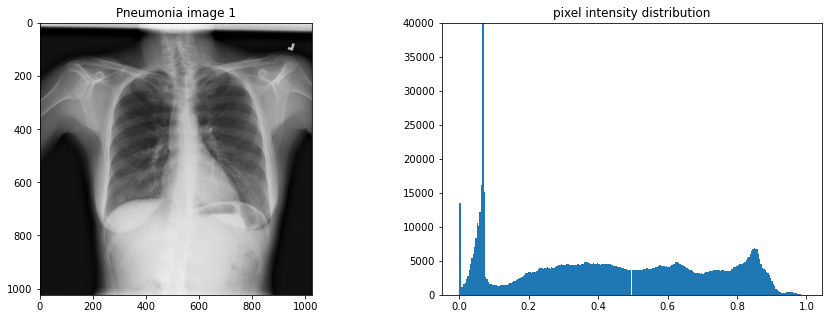

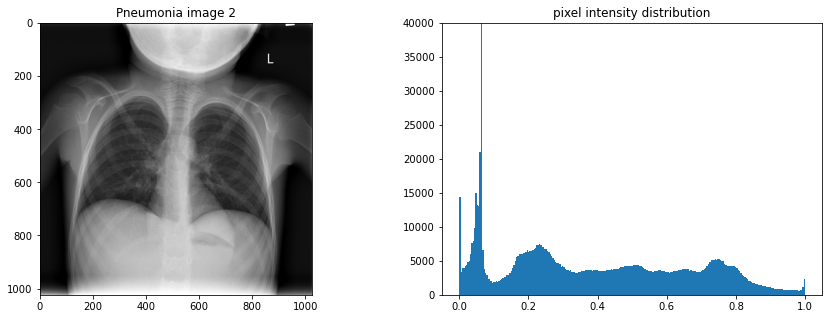

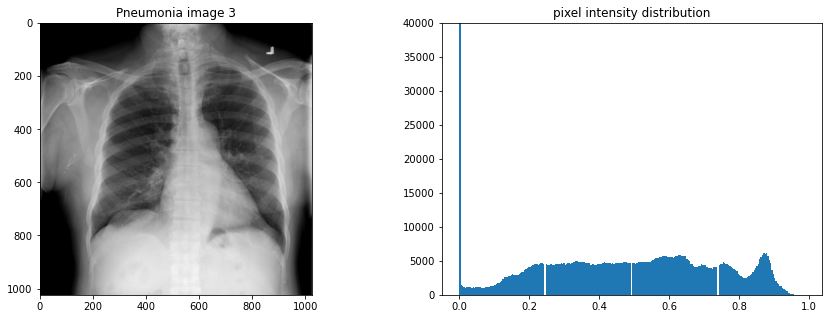

In [124]:
plot_image_distributions(pneumonia_img,'Pneumonia')

## Discussion

In the intensity distributions, there is a spike around 0.0-0.1. This an be attributed to some images have a black frame around the image, so there is a large volume of low intensity pixels.

In the xrays with No Finding, distribution ranges between 0.2-0.8 with a peak between 0.6-0.7. The mean was lower than in the pneumonia xrays that i plotted.

In the pneumonia xrays, there is a larger  volume of pixels in the intensity range above 0.8 and the peak is occuring around 0.8-0.9. The distribution is spread more evenly across the range 0-1. The mean was higher than for the no finding plots.

Even within a disease the intensity distribution can vary. For example the three scans for Atelestasis are significantly different from each other with differnt ranges and peaks. This shows the challenges in using pixel level intensity as a feature.

The distribution of pleural thickening, consolidation and fibrosis look similar to that of pneumonia, whereas mass and nodule distributions are different.

Using pixel level intensity for my modelling would be challenging to achieve good results because there are disease that have a similar distribution to pneumonia and also there is variation within the disease labels. In addition, I isolated xrays with only one finding for this analysis. With two or more diseases present, it would be even more challenging to pull out a discerning intensity feature.
